In [1]:
import pandas as pd

guest =pd.read_csv('OrderDetails_2025_10_01-2025_11_30.csv')

In [2]:
# Remove incorrect import, fix column conversion warnings and make the code robust.

# Ensure 'Opened' is datetime
guest['Opened'] = pd.to_datetime(guest['Opened'], errors='coerce')

# Select only Dine In rows
guest_comal = guest[guest['Dining Options'] == 'Dine In'].copy()

# Add column for day of week
guest_comal['DayOfWeek'] = guest_comal['Opened'].dt.day_name()

#Add number week 
guest_comal['Week'] = guest_comal['Opened'].dt.isocalendar().week

# Remove the outlier: row where Week==41 and DayOfWeek=='Saturday' and '# of Guests'==1
guest_comal = guest_comal[~((guest_comal['Week'] == 41) & 
                           (guest_comal['DayOfWeek'] == 'Saturday') & 
                           (guest_comal['# of Guests'] == 1))]







/var/folders/nr/nkywtxqj4vq5n8czt847c2lc0000gp/T/ipykernel_96706/55325014.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  guest['Opened'] = pd.to_datetime(guest['Opened'], errors='coerce')


In [3]:
# Group by both day of week and week, summing number of guests for each combination
guests_by_day_and_week = guest_comal.groupby(['Week', 'DayOfWeek'])['# of Guests'].sum().reset_index()

guests_by_day_and_week

,Week,DayOfWeek,# of Guests
0,40,Friday,274
1,40,Saturday,324
2,40,Sunday,157
3,40,Thursday,499
4,40,Wednesday,105
5,41,Friday,236
6,41,Monday,139
7,41,Sunday,138
8,41,Thursday,191
9,41,Tuesday,176


In [4]:
from collections import defaultdict

fridays = guest_comal[guest_comal['DayOfWeek'] == 'Friday']

# Sum number of guests per hour (offset from 17:00) for each Friday (by week)
friday_hours_by_week = (
    fridays
    .assign(hour_offset=fridays['Opened'].dt.hour - 17)
    .groupby(['Week', 'hour_offset'])['# of Guests']
    .sum()
    .unstack(fill_value=0)
)
friday_hours_by_week

hour_offset,0,1,2,3,4
Week,,,,,
40,77,83,73,30,11
41,90,53,65,22,6
42,93,159,92,27,17
43,49,104,94,42,13
44,30,32,34,15,11
45,99,98,71,44,19
46,96,93,84,34,6
47,78,79,68,28,23
48,69,44,32,22,5


In [5]:
avg_friday_guests_per_hour = friday_hours_by_week.mean(axis=0)
avg_friday_guests_per_hour

hour_offset
0    75.666667
1    82.777778
2    68.111111
3    29.333333
4    12.333333
dtype: float64

In [6]:
def get_hourly_guest_totals_by_week(df, day_name):
    """
    For the given guest_comal DataFrame and a day of the week (e.g. 'Friday'), 
    return a DataFrame indexed by Week with columns for each hour offset from 17:00,
    where the value is the sum of '# of Guests' for the specified day.
    """
    specific_day = df[df['DayOfWeek'] == day_name]
    hourly_by_week = (
        specific_day
        .assign(hour_offset=specific_day['Opened'].dt.hour-12)
        .groupby(['Week', 'hour_offset'])['# of Guests']
        .sum()
        .unstack(fill_value=0)
    )
    return hourly_by_week


In [7]:
averages = defaultdict(dict)

mondays = get_hourly_guest_totals_by_week(guest_comal, 'Monday')
averages['Monday'] = mondays.mean(axis=0)

tuesdays = get_hourly_guest_totals_by_week(guest_comal, 'Tuesday')
averages['Tuesday'] = tuesdays.mean(axis=0)

wednesdays = get_hourly_guest_totals_by_week(guest_comal, 'Wednesday')
averages['Wednesday'] = wednesdays.mean(axis=0)

thursdays = get_hourly_guest_totals_by_week(guest_comal, 'Thursday')
averages['Thursday'] = thursdays.mean(axis=0)

fridays = get_hourly_guest_totals_by_week(guest_comal, 'Friday')
averages['Friday'] = fridays.mean(axis=0)

saturdays = get_hourly_guest_totals_by_week(guest_comal, 'Saturday')
averages['Saturday'] = saturdays.mean(axis=0)

sundays = get_hourly_guest_totals_by_week(guest_comal, 'Sunday')
averages['Sunday'] = sundays.mean(axis=0)

averages



defaultdict(dict,
            {'Monday': hour_offset
             5    97.625
             6    61.250
             7    36.875
             8     7.500
             dtype: float64,
             'Tuesday': hour_offset
             5    77.625
             6    47.750
             7    34.000
             8     5.500
             dtype: float64,
             'Wednesday': hour_offset
             4     8.888889
             5    53.666667
             6    54.444444
             7    32.555556
             8    10.444444
             9     0.222222
             dtype: float64,
             'Thursday': hour_offset
             4       0.250
             5     130.500
             6      67.500
             7      40.000
             8      40.875
             9      24.000
             10      0.375
             dtype: float64,
             'Friday': hour_offset
             5    75.666667
             6    82.777778
             7    68.111111
             8    29.333333
             9  

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [9]:
hour_offsets = averages['Friday'].keys()
hour_offsets = hour_offsets.tolist()

average_guests_per_hour = averages['Friday']
arrival_rates_per_hour = average_guests_per_hour.tolist()

time_minutes = np.array(hour_offsets) * 60

# Convert to minutes and per-minute rates
time_minutes = np.array(hour_offsets) * 60  # [0, 60, 120, 180, 240]
arrival_rates_per_minute = np.array(arrival_rates_per_hour) / 60  # Convert to guests/min

In [10]:
def gaussian_peak_model(t, lambda_base, lambda_peak_multiplier, peak_time, peak_width):
    """
    NHPP rate function: lambda_base + lambda_peak_multiplier * exp(-((t - peak_time)² / (2 * peak_width²)))
    
    Parameters:
    - t: time in minutes
    - lambda_base: base arrival rate (guests/min)
    - lambda_peak_multiplier: peak intensity above base (guests/min)
    - peak_time: time of peak (minutes)
    - peak_width: width of peak (minutes)
    """
    return lambda_base + lambda_peak_multiplier * np.exp(-((t - peak_time) ** 2) / (2 * peak_width ** 2))

In [11]:
# Initial parameter guesses based on your data
# lambda_base: minimum rate (hour 4 = 12.33/60 ≈ 0.205 guests/min)
# lambda_peak_multiplier: peak - base (82.78/60 - 12.33/60 ≈ 1.17 guests/min)
# peak_time: around hour 1 = 60 minutes
# peak_width: guess around 60-90 minutes for spread

initial_guess = [
    12.33 / 60,  # lambda_base (lowest rate converted to per-minute)
    70.45 / 60,  # lambda_peak_multiplier (82.78 - 12.33, converted)
    60.0,        # peak_time (around hour 1)
    90.0         # peak_width (spread of peak)
]

# Fit the model
popt, pcov = curve_fit(
    gaussian_peak_model,
    time_minutes,
    arrival_rates_per_minute,
    p0=initial_guess,
    bounds=([0, 0, 0, 10], [np.inf, np.inf, 600, 200])  # Reasonable bounds
)

lambda_base_fit, lambda_peak_multiplier_fit, peak_time_fit, peak_width_fit = popt

print(f"Fitted Parameters:")
print(f"  lambda_base: {lambda_base_fit:.6f} guests/min")
print(f"  lambda_peak_multiplier: {lambda_peak_multiplier_fit:.6f} guests/min")
print(f"  peak_time: {peak_time_fit:.2f} minutes")
print(f"  peak_width: {peak_width_fit:.2f} minutes")

Fitted Parameters:
  lambda_base: 0.013322 guests/min
  lambda_peak_multiplier: 1.417097 guests/min
  peak_time: 349.15 minutes
  peak_width: 93.15 minutes


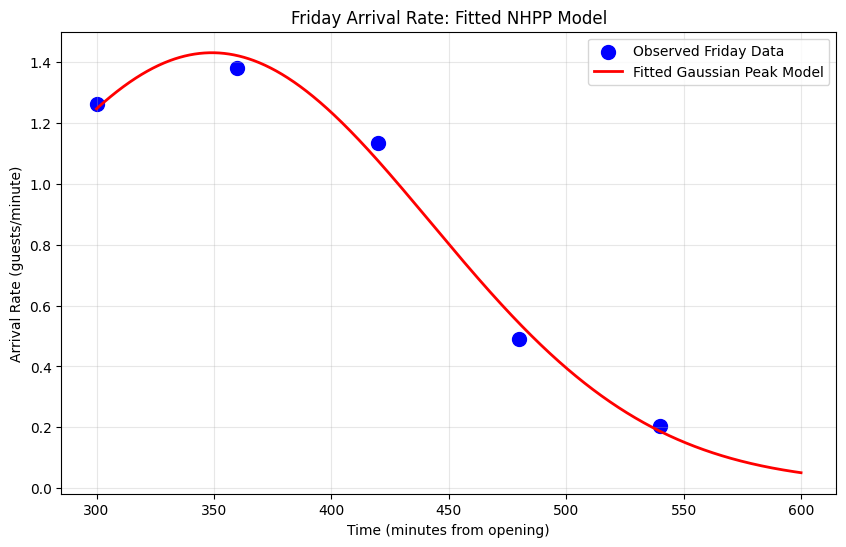

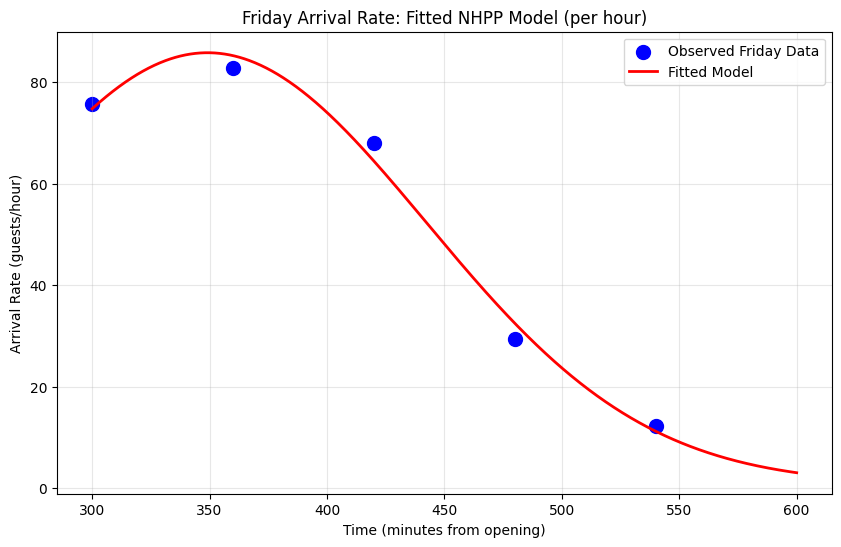

In [12]:
# Generate smooth curve for plotting
t_smooth = np.linspace(300, 600, 1000)
fitted_curve = gaussian_peak_model(t_smooth, *popt)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(time_minutes, arrival_rates_per_minute, s=100, label='Observed Friday Data', color='blue')
plt.plot(t_smooth, fitted_curve, 'r-', label='Fitted Gaussian Peak Model', linewidth=2)
plt.xlabel('Time (minutes from opening)')
plt.ylabel('Arrival Rate (guests/minute)')
plt.title('Friday Arrival Rate: Fitted NHPP Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Also plot in guests/hour for easier interpretation
plt.figure(figsize=(10, 6))
plt.scatter(time_minutes, arrival_rates_per_hour, s=100, label='Observed Friday Data', color='blue')
plt.plot(t_smooth, fitted_curve * 60, 'r-', label='Fitted Model', linewidth=2)
plt.xlabel('Time (minutes from opening)')
plt.ylabel('Arrival Rate (guests/hour)')
plt.title('Friday Arrival Rate: Fitted NHPP Model (per hour)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Calculate predicted rates at observed times
predicted_rates = gaussian_peak_model(time_minutes, *popt)

# Calculate R-squared
ss_res = np.sum((arrival_rates_per_minute - predicted_rates) ** 2)
ss_tot = np.sum((arrival_rates_per_minute - np.mean(arrival_rates_per_minute)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R-squared: {r_squared:.4f}")
print(f"Mean absolute error: {np.mean(np.abs(arrival_rates_per_minute - predicted_rates)):.6f} guests/min")

R-squared: 0.9918
Mean absolute error: 0.037602 guests/min


In [14]:
def get_hourly_party_totals_by_week(df, day_name):
    """
    For the given guest_comal DataFrame and a day of the week (e.g. 'Friday'),
    return a DataFrame indexed by Week with columns for each hour offset from 17:00,
    where the value is the number of parties for the specified day (i.e., row count, not guest sum).
    """
    specific_day = df[df['DayOfWeek'] == day_name]
    hourly_by_week = (
        specific_day
        .assign(hour_offset=specific_day['Opened'].dt.hour-12)
        .groupby(['Week', 'hour_offset'])
        .size()  # counts the number of parties (rows)
        .unstack(fill_value=0)
    )
    return hourly_by_week

In [16]:
average_parties = defaultdict(dict)

mondays = get_hourly_party_totals_by_week(guest_comal, 'Monday')
average_parties['Monday'] = mondays.mean(axis=0)

tuesdays = get_hourly_party_totals_by_week(guest_comal, 'Tuesday')
average_parties['Tuesday'] = tuesdays.mean(axis=0)

wednesdays = get_hourly_party_totals_by_week(guest_comal, 'Wednesday')
average_parties['Wednesday'] = wednesdays.mean(axis=0)

thursdays = get_hourly_party_totals_by_week(guest_comal, 'Thursday')
average_parties['Thursday'] = thursdays.mean(axis=0)

fridays = get_hourly_party_totals_by_week(guest_comal, 'Friday')
average_parties['Friday'] = fridays.mean(axis=0)

saturdays = get_hourly_party_totals_by_week(guest_comal, 'Saturday')
average_parties['Saturday'] = saturdays.mean(axis=0)

sundays = get_hourly_party_totals_by_week(guest_comal, 'Sunday')
average_parties['Sunday'] = sundays.mean(axis=0)

average_parties



defaultdict(dict,
            {'Monday': hour_offset
             5    12.750
             6    17.000
             7    13.375
             8     4.375
             dtype: float64,
             'Tuesday': hour_offset
             5    23.375
             6    15.750
             7    11.875
             8     3.250
             dtype: float64,
             'Wednesday': hour_offset
             4     0.111111
             5    19.666667
             6    16.666667
             7    12.222222
             8     4.777778
             9     0.222222
             dtype: float64,
             'Thursday': hour_offset
             4      0.250
             5     19.500
             6     17.250
             7     17.500
             8     24.500
             9     17.750
             10     0.375
             dtype: float64,
             'Friday': hour_offset
             5    27.111111
             6    30.111111
             7    27.777778
             8    12.777778
             9     7.00

In [17]:
hour_offsets = average_parties['Friday'].keys()
hour_offsets = hour_offsets.tolist()

average_parties_per_hour = average_parties['Friday']
arrival_rates_per_hour = average_parties_per_hour.tolist()

time_minutes = np.array(hour_offsets) * 60

# Convert to minutes and per-minute rates
time_minutes = np.array(hour_offsets) * 60  # [0, 60, 120, 180, 240]
arrival_rates_per_minute = np.array(arrival_rates_per_hour) / 60  # Convert to guests/min

In [18]:
# Initial parameter guesses based on your data
# lambda_base: minimum rate (hour 4 = 12.33/60 ≈ 0.205 guests/min)
# lambda_peak_multiplier: peak - base (82.78/60 - 12.33/60 ≈ 1.17 guests/min)
# peak_time: around hour 1 = 60 minutes
# peak_width: guess around 60-90 minutes for spread

initial_guess = [
    7 / 60,  # lambda_base (lowest rate converted to per-minute)
    23.111111 / 60,  # lambda_peak_multiplier (82.78 - 12.33, converted)
    60.0,        # peak_time (around hour 1)
    90.0         # peak_width (spread of peak)
]

# Fit the model
popt, pcov = curve_fit(
    gaussian_peak_model,
    time_minutes,
    arrival_rates_per_minute,
    p0=initial_guess,
    bounds=([0, 0, 0, 10], [np.inf, np.inf, 600, 200])  # Reasonable bounds
)

lambda_base_fit, lambda_peak_multiplier_fit, peak_time_fit, peak_width_fit = popt

print(f"Fitted Parameters:")
print(f"  lambda_base: {lambda_base_fit:.6f} parties/min")
print(f"  lambda_peak_multiplier: {lambda_peak_multiplier_fit:.6f} parties/min")
print(f"  peak_time: {peak_time_fit:.2f} minutes")
print(f"  peak_width: {peak_width_fit:.2f} minutes")

Fitted Parameters:
  lambda_base: 0.036463 parties/min
  lambda_peak_multiplier: 0.491057 parties/min
  peak_time: 357.39 minutes
  peak_width: 92.84 minutes


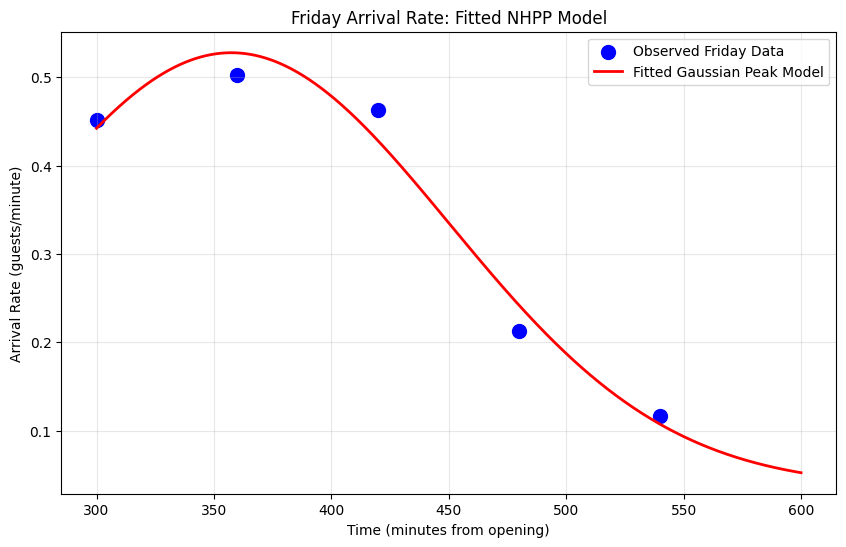

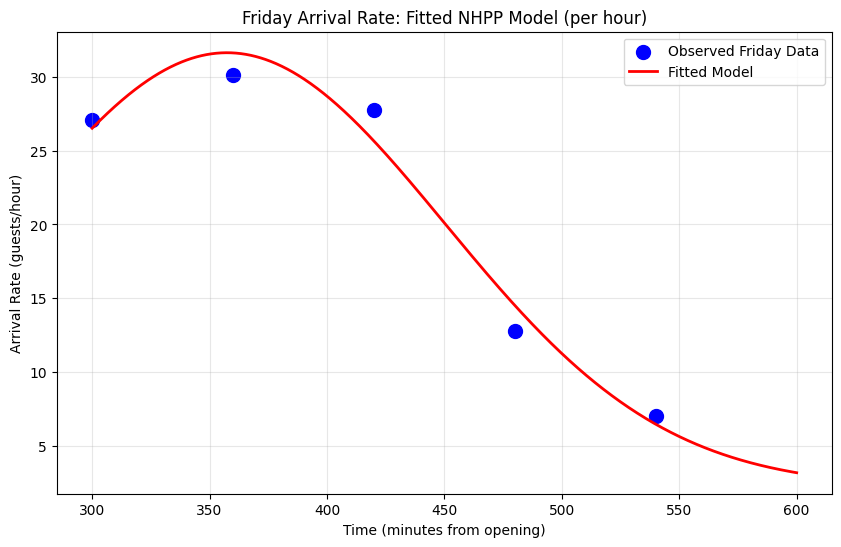

In [ ]:
# Generate smooth curve for plotting
t_smooth = np.linspace(300, 600, 1000)
fitted_curve = gaussian_peak_model(t_smooth, *popt)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(time_minutes, arrival_rates_per_minute, s=100, label='Observed Friday Data', color='blue')
plt.plot(t_smooth, fitted_curve, 'r-', label='Fitted Gaussian Peak Model', linewidth=2)
plt.xlabel('Time (minutes from opening)')
plt.ylabel('Arrival Rate (parties/minute)')
plt.title('Friday Arrival Rate: Fitted NHPP Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Also plot in guests/hour for easier interpretation
plt.figure(figsize=(10, 6))
plt.scatter(time_minutes, arrival_rates_per_hour, s=100, label='Observed Friday Data', color='blue')
plt.plot(t_smooth, fitted_curve * 60, 'r-', label='Fitted Model', linewidth=2)
plt.xlabel('Time (minutes from opening)')
plt.ylabel('Arrival Rate (parties/hour)')
plt.title('Friday Arrival Rate: Fitted NHPP Model (per hour)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()